In [1]:
from IPython.display import display, Image

## Creating our first workflow

Run `docker compose up -d` from the root directory to spin up your n8n service. You will then be able to access it from `http://localhost:5678`

> When first accessing the service you'll be prompted to create a user login account, and then prompted to log in.

Once logged in you should see a page similar to this.

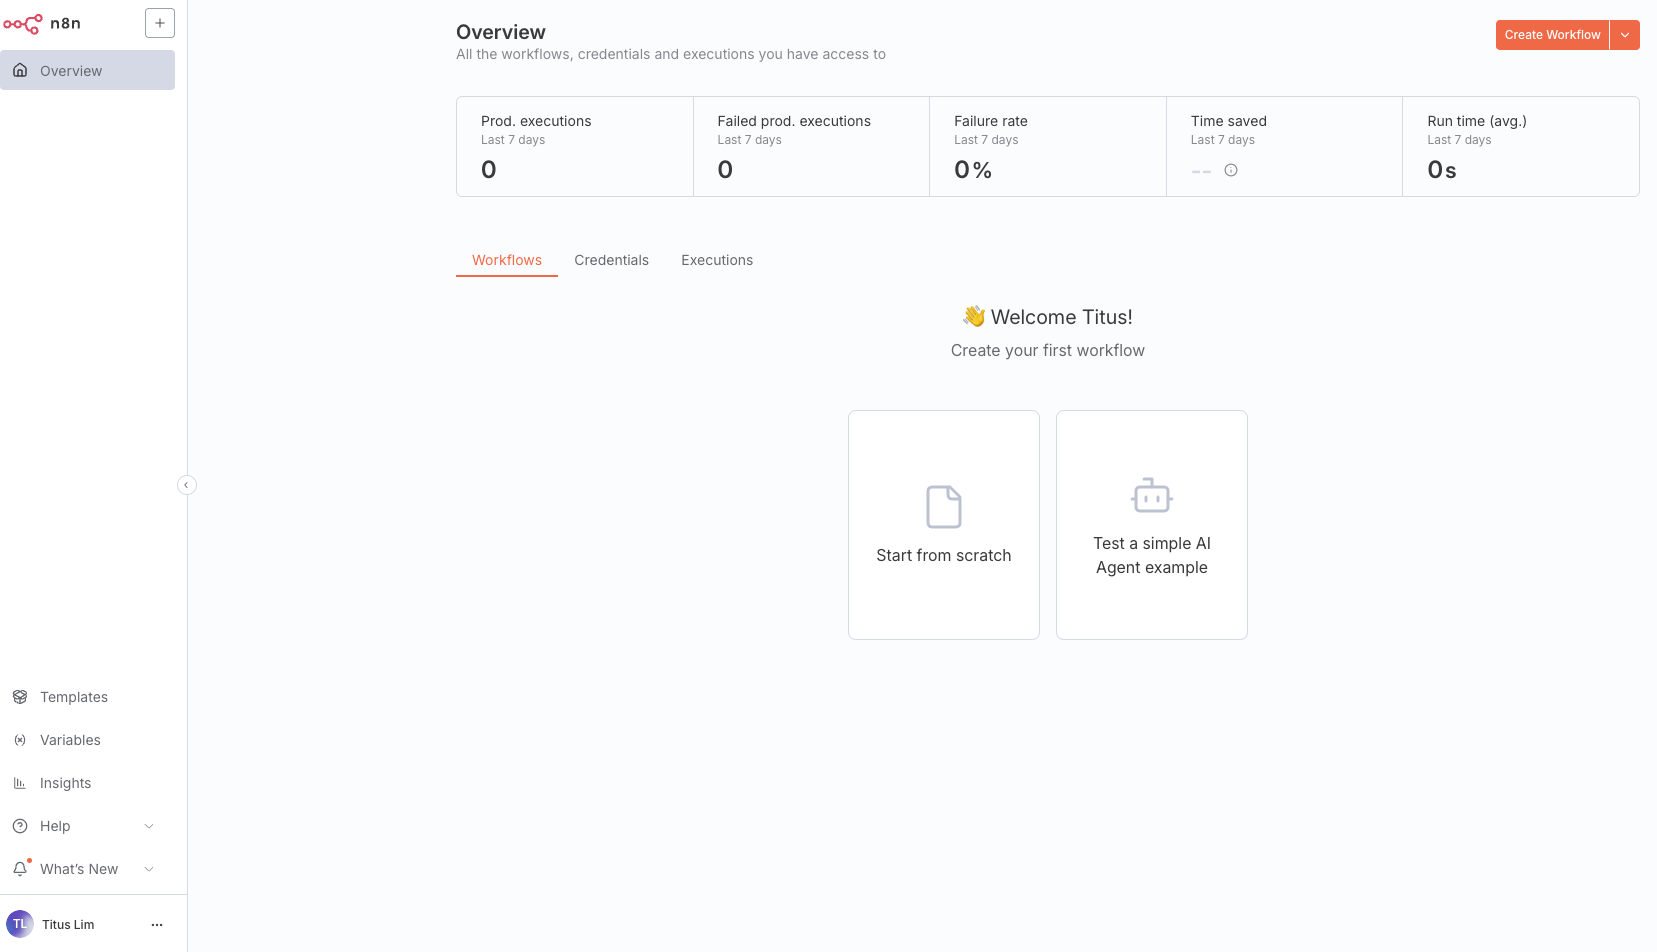

In [2]:
display(Image("../images/1. n8n_home.png"))

Clicking on `Test a simple AI agent example` loads a sample n8n agent workflow template with just 2 nodes - a chat message trigger node and an agent node. When you click to add a chat model, you'll be greeted with a vast selection of Language Models

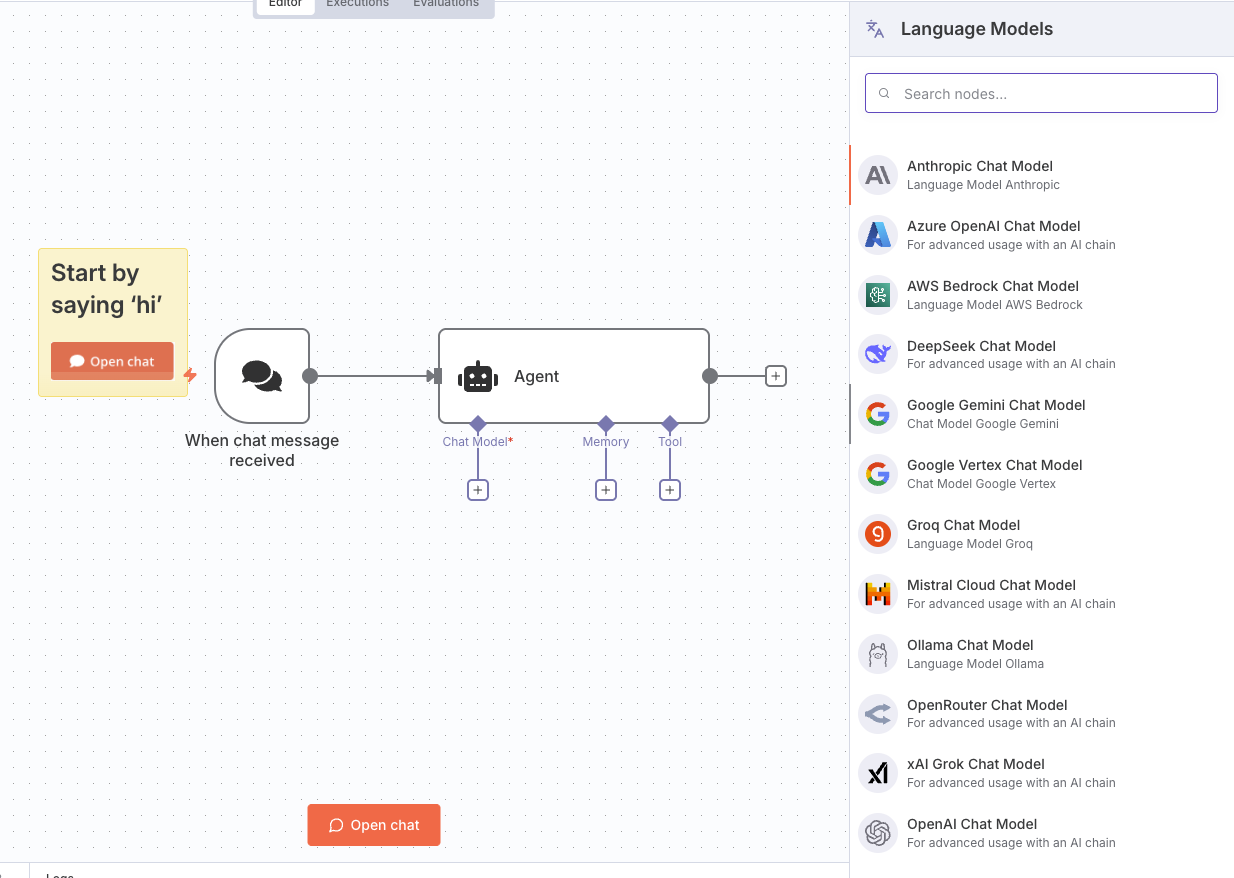

In [4]:
display(Image("../images/2. Add LLM Node.png"))

This is where it gets a little disappointing. Clicking on any LLM provider (say Mistral), you have to key in the credentials from scratch instead of being able to "share" any secrets with your colleagues.

> You'll have to upgrade to an enterprise plan to do that

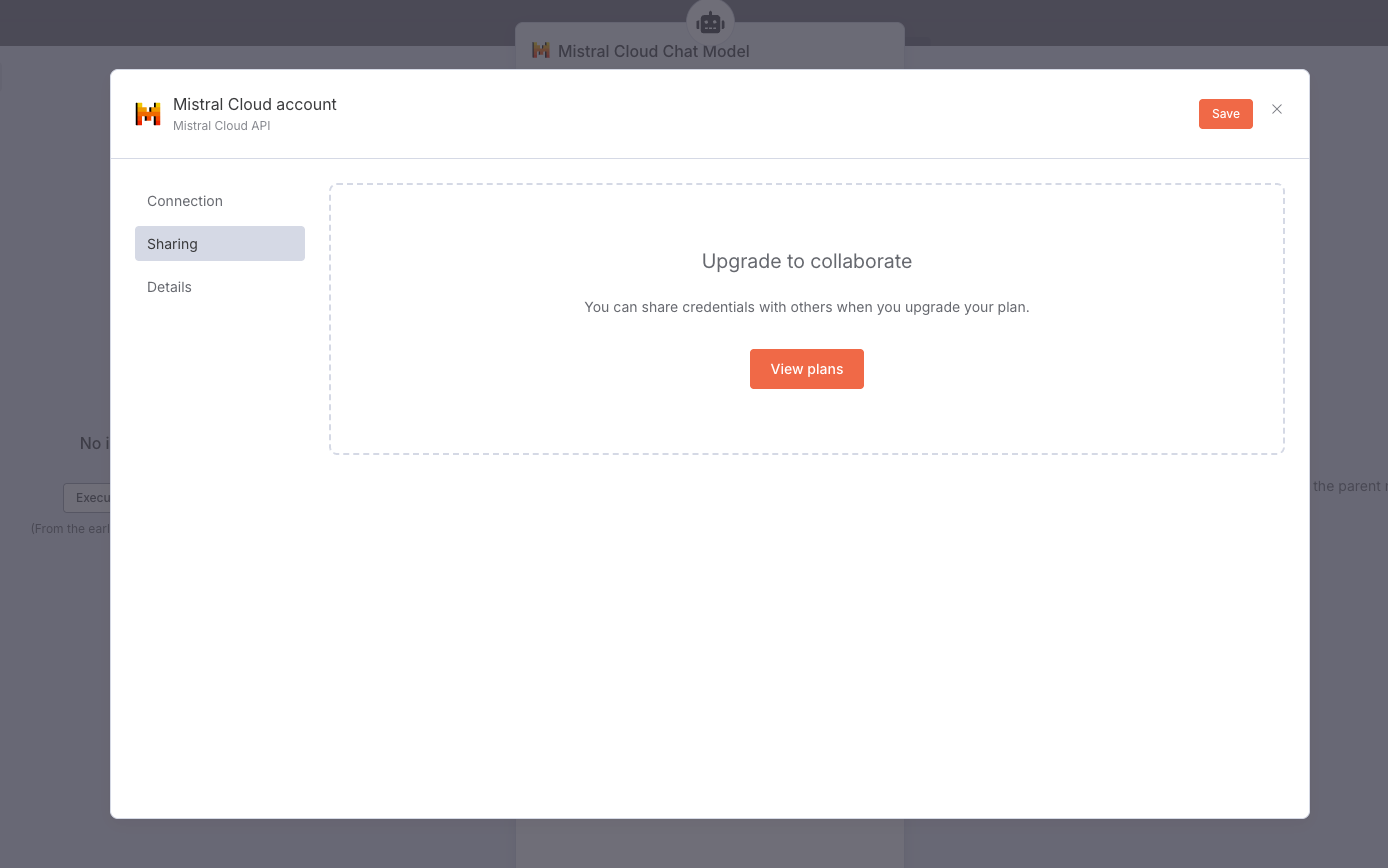

In [5]:
display(Image("../images/3. Upgrade plan to share secrets.png"))

Key in your credentials into your preferred LLM provider and click "test connection"

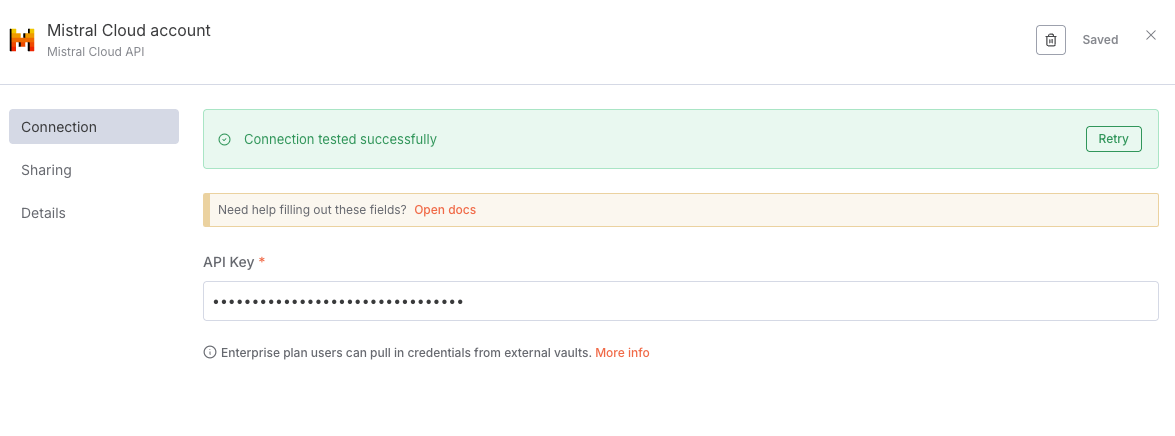

In [6]:
display(Image("../images/4. Test connection.png"))

All agent nodes in n8n require a memory tool. Clicking on the `+` sign below memory and you'll be able to see that there are many memory types available. For now, click on "simple memory" to configure a session-based in-memory datastore.

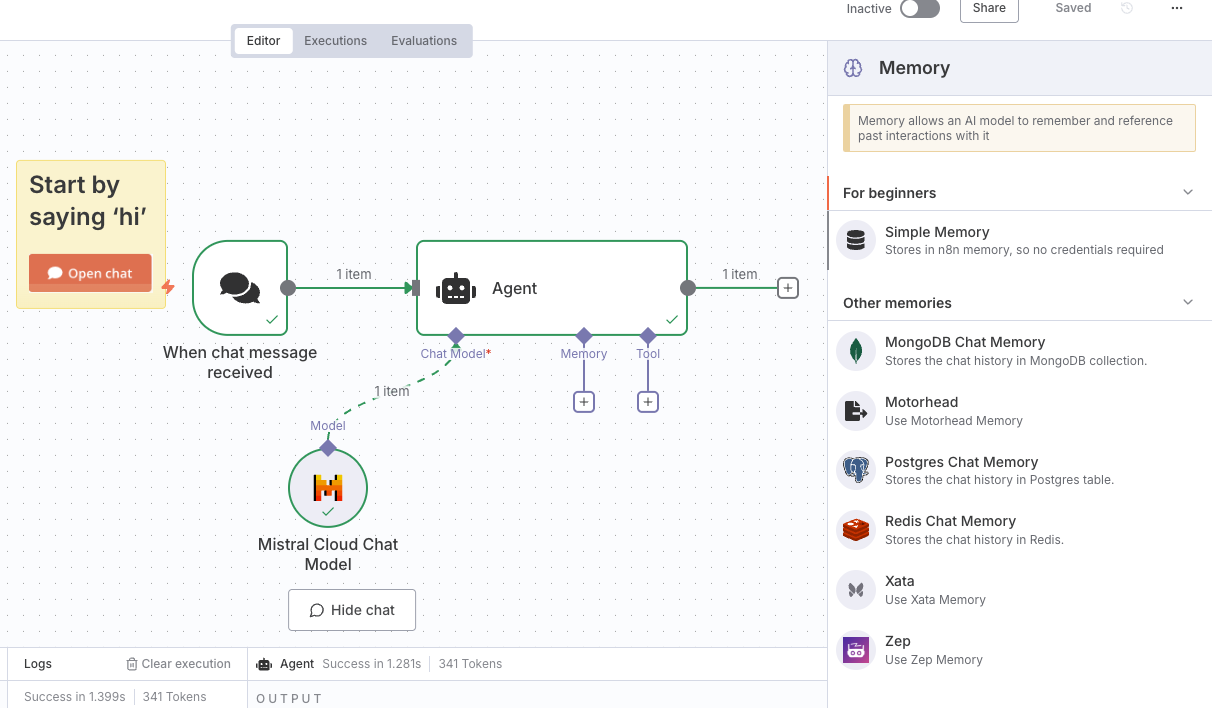

In [7]:
display(Image("../images/5. Memory.png"))

You can leave the memory defaults or configure the context window length to your preference.
> The default context window length is 5

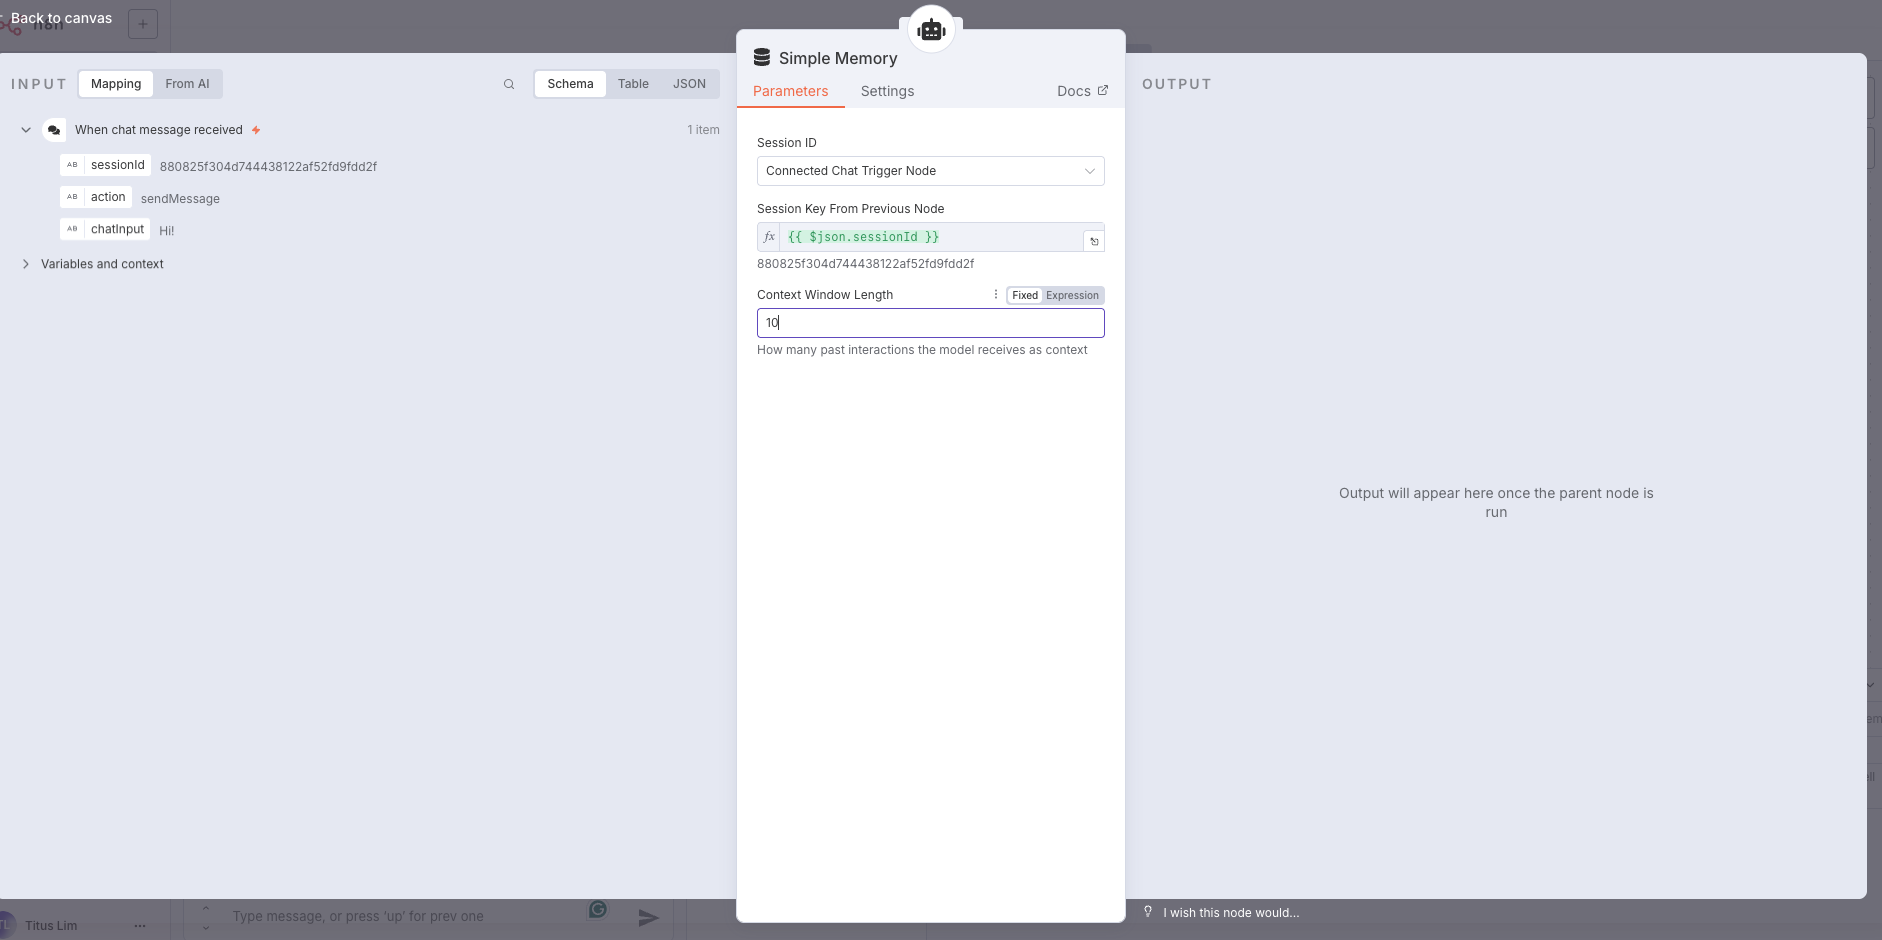

In [9]:
display(Image("../images/6a. Setup before chat.png"))

I connected my agent to my Google Calendar. To do this you'll have to follow the instructions on n8n to create an OAuth2 credential on Google Cloud Platform - I already have this setup so I was simply able to import it.

> Do also run the notebook `98. ngrok_setup.ipynb` to expose your locahost n8n endpoint as a public URL. Google Cloud Platform only allows for their API keys to be called by public URLs and not localhost served applications.

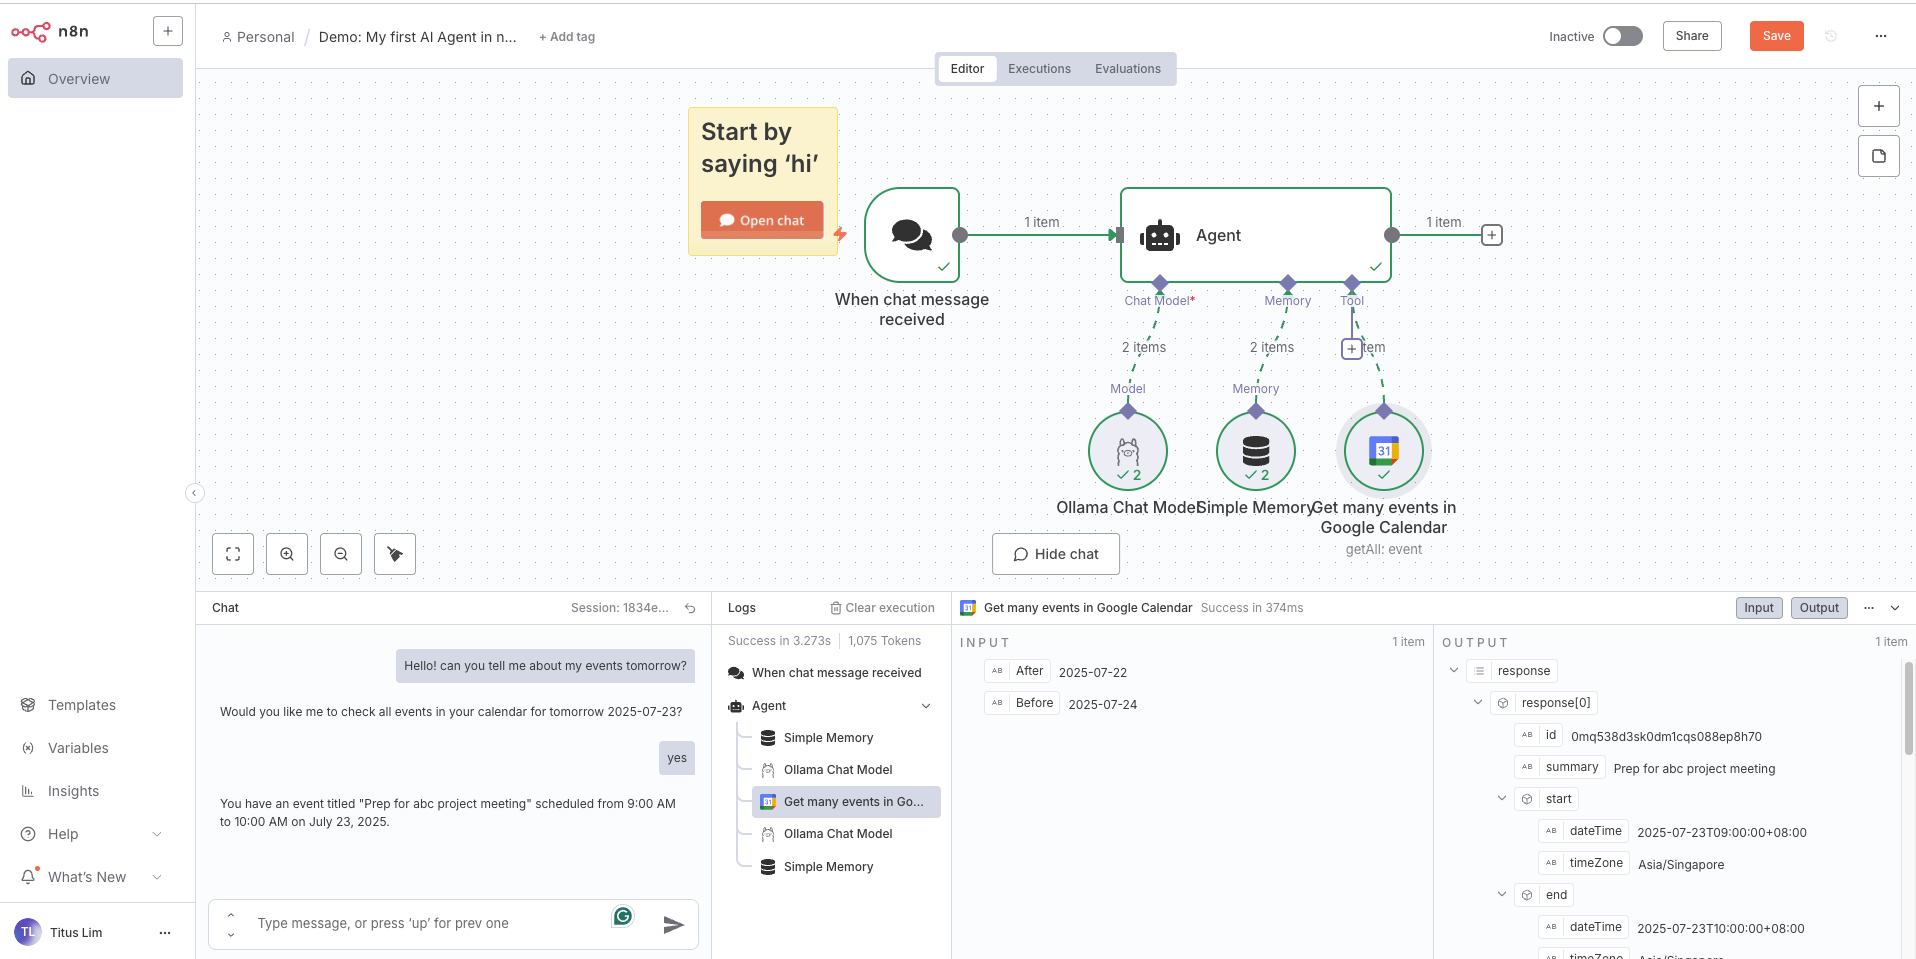

In [10]:
display(Image("../images/7. Connect to Google Calendar.png"))

### Now let's chat with our agent!

I told my agent to create a google calendar event called "Lunch" for 24th July 2025.

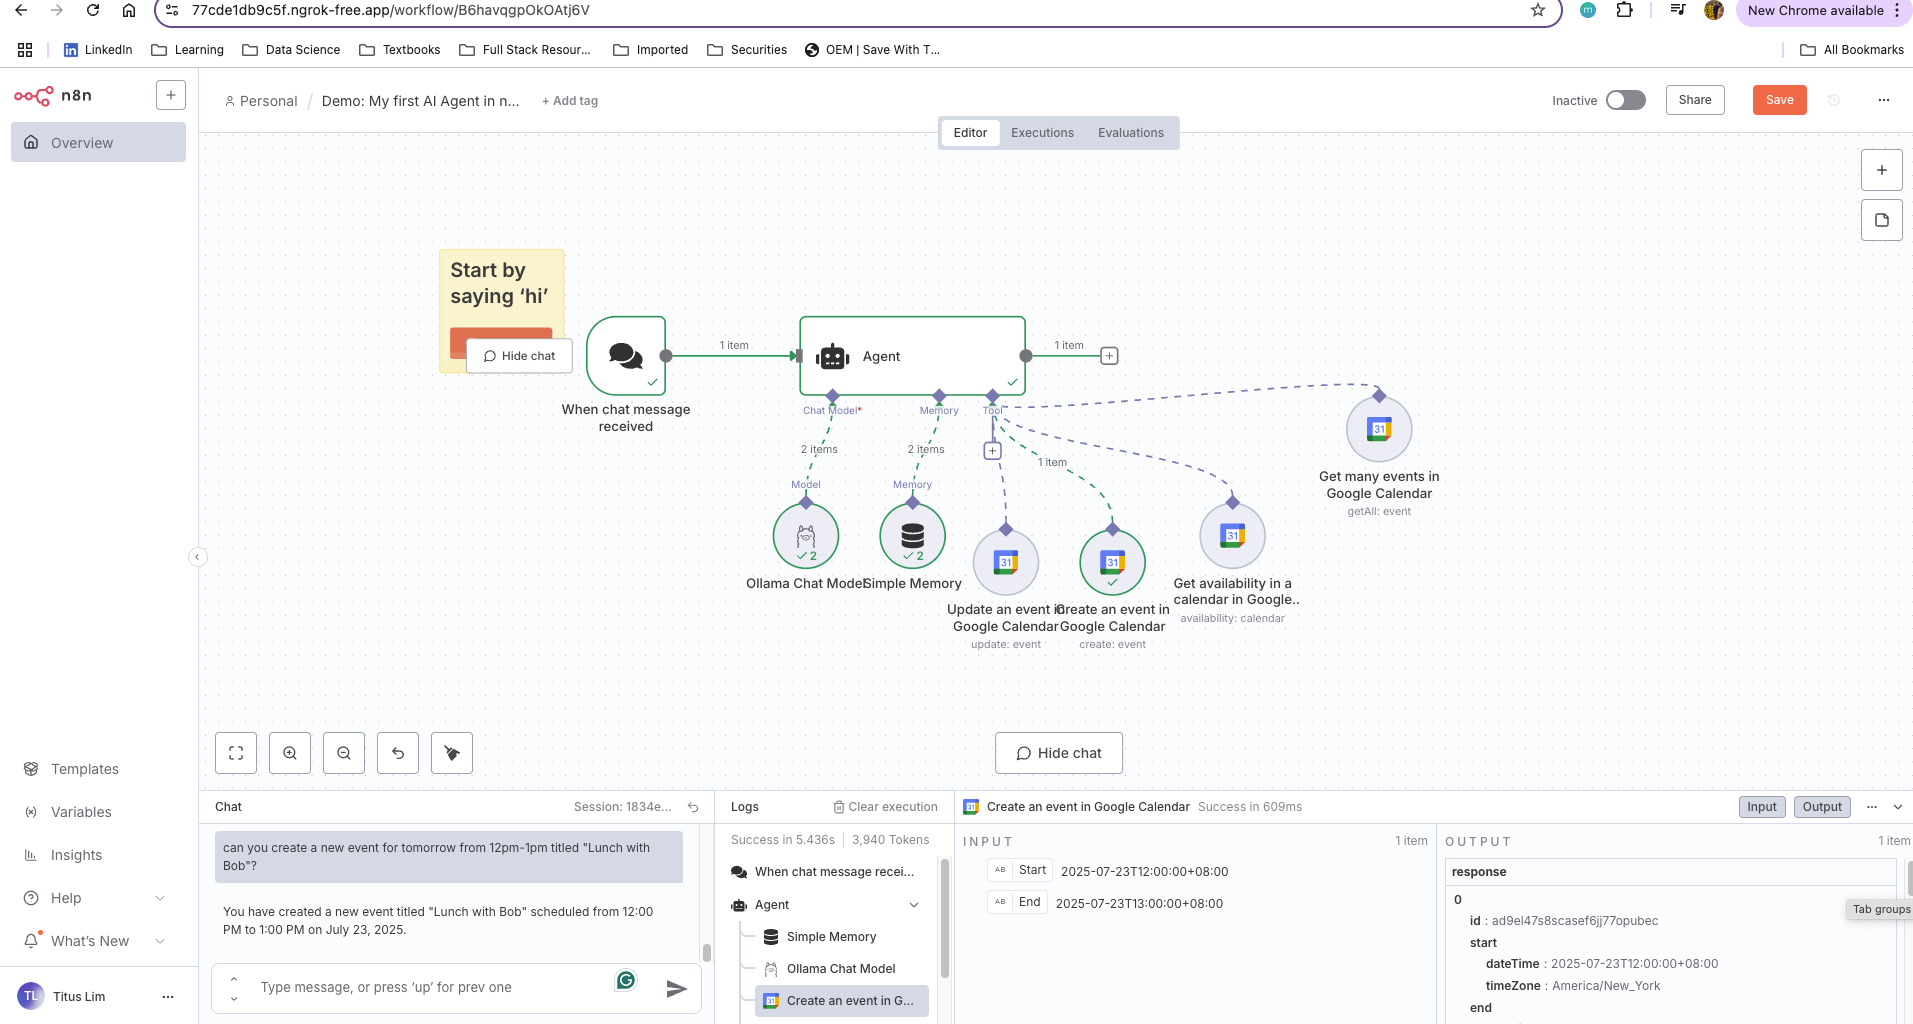

In [12]:
display(Image("../images/8. Create Google Calendar Event.png"))

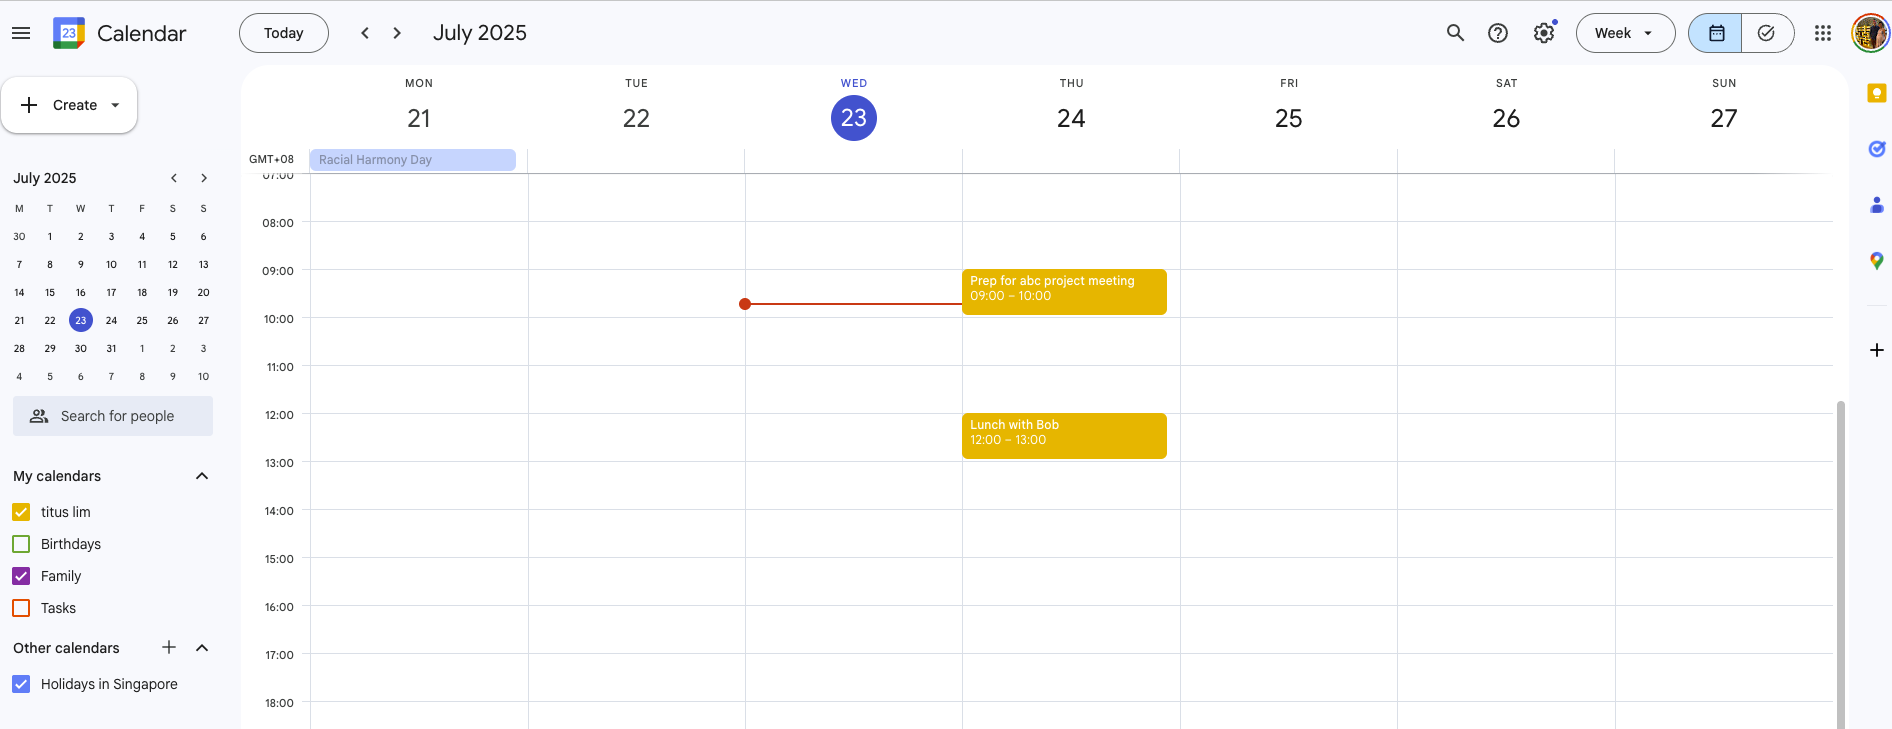

In [13]:
display(Image("../images/9. View calendar.png"))

That's great! I wanted to build my own multi-agent system workflow to call this workflow as a tool - so I had to convert this workflow into a sub workflow.

To do that, change the trigger from a chat-based trigger to a `When Executed by Another Workflow` trigger.

> Set the input parameters to accept **all** input from the master workflow - optionally you can further configure this.

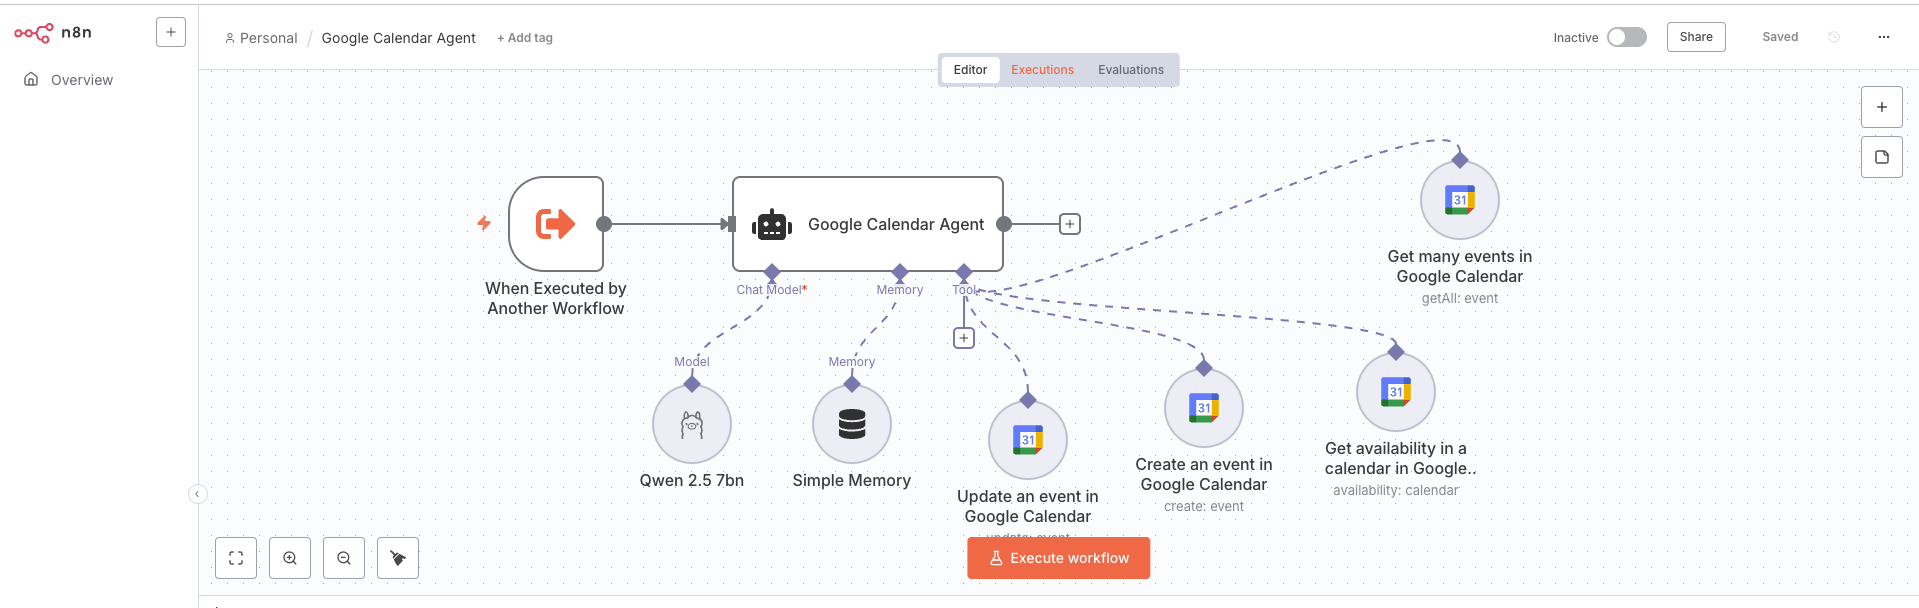

In [14]:
display(Image("../images/10. Change Google Agent to SubWorkflow.png"))

## Creating our own workflow

Click `create a new workflow` and you'll be greeted with a blank canvas

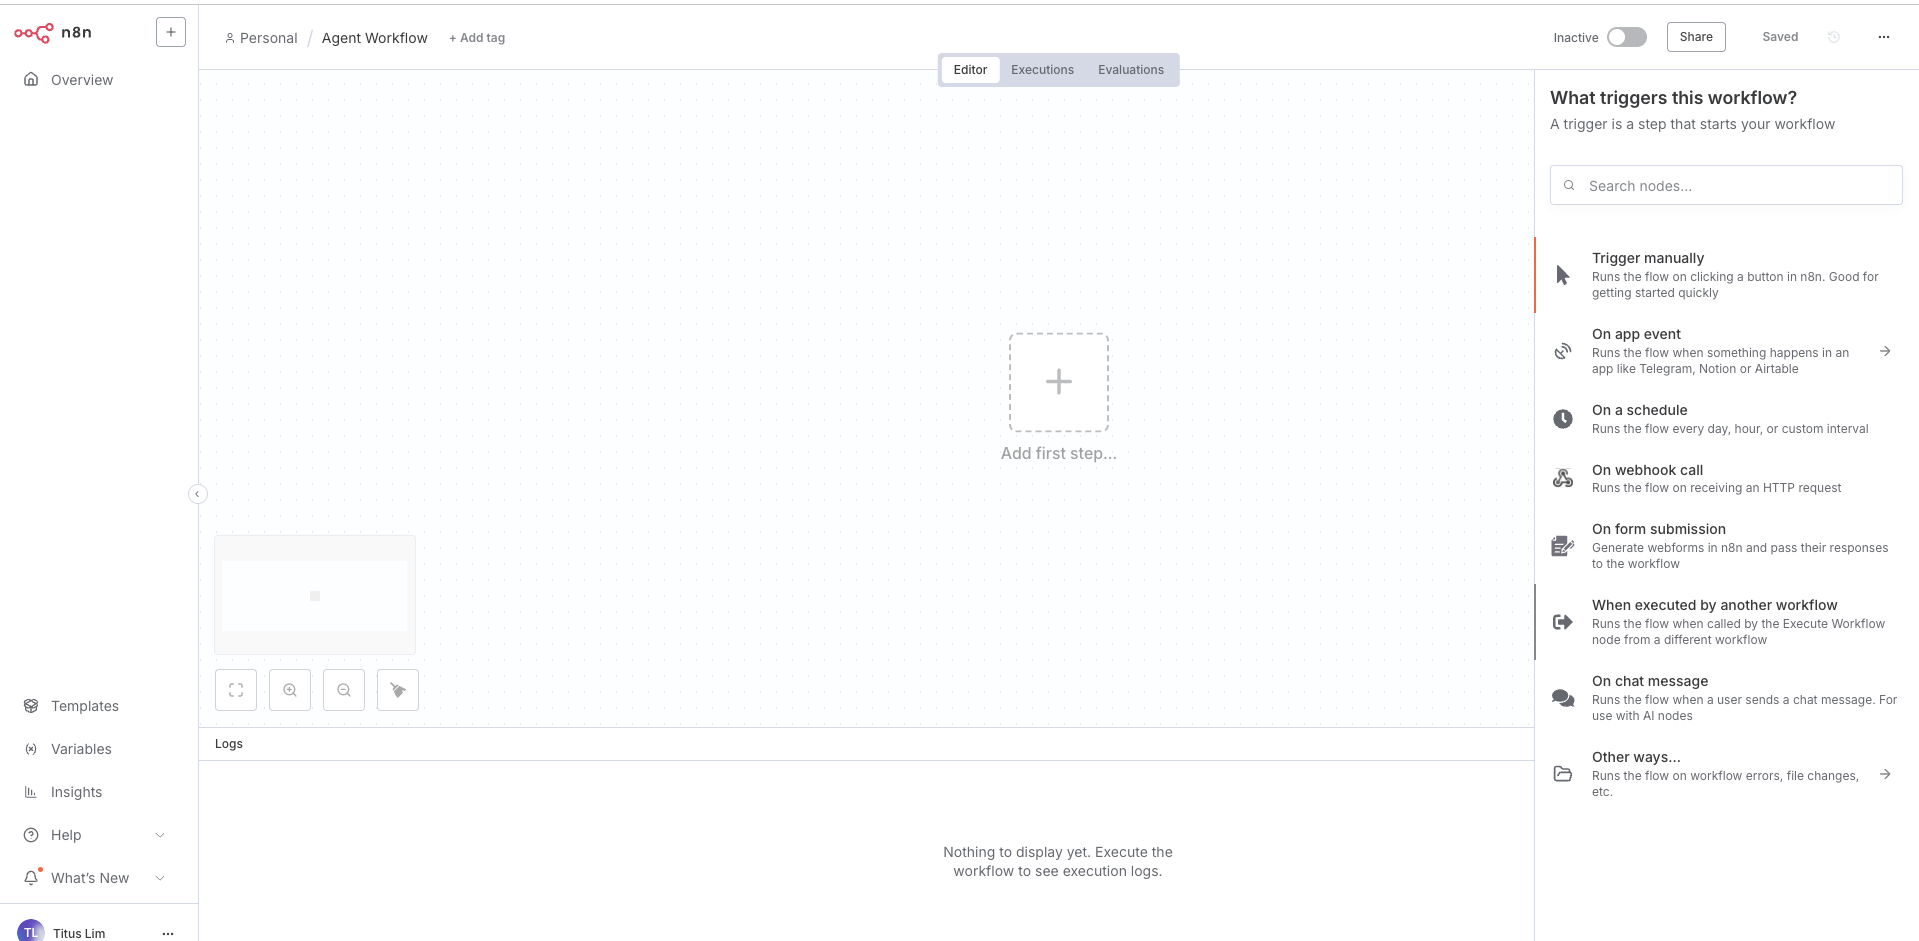

In [15]:
display(Image("../images/11. Workflow from scratch step 1.png"))

Like the sample agent template, click to add a chat trigger node. Be sure to select the `make chat publicly available` option because it allows us to interact with the chat UI.

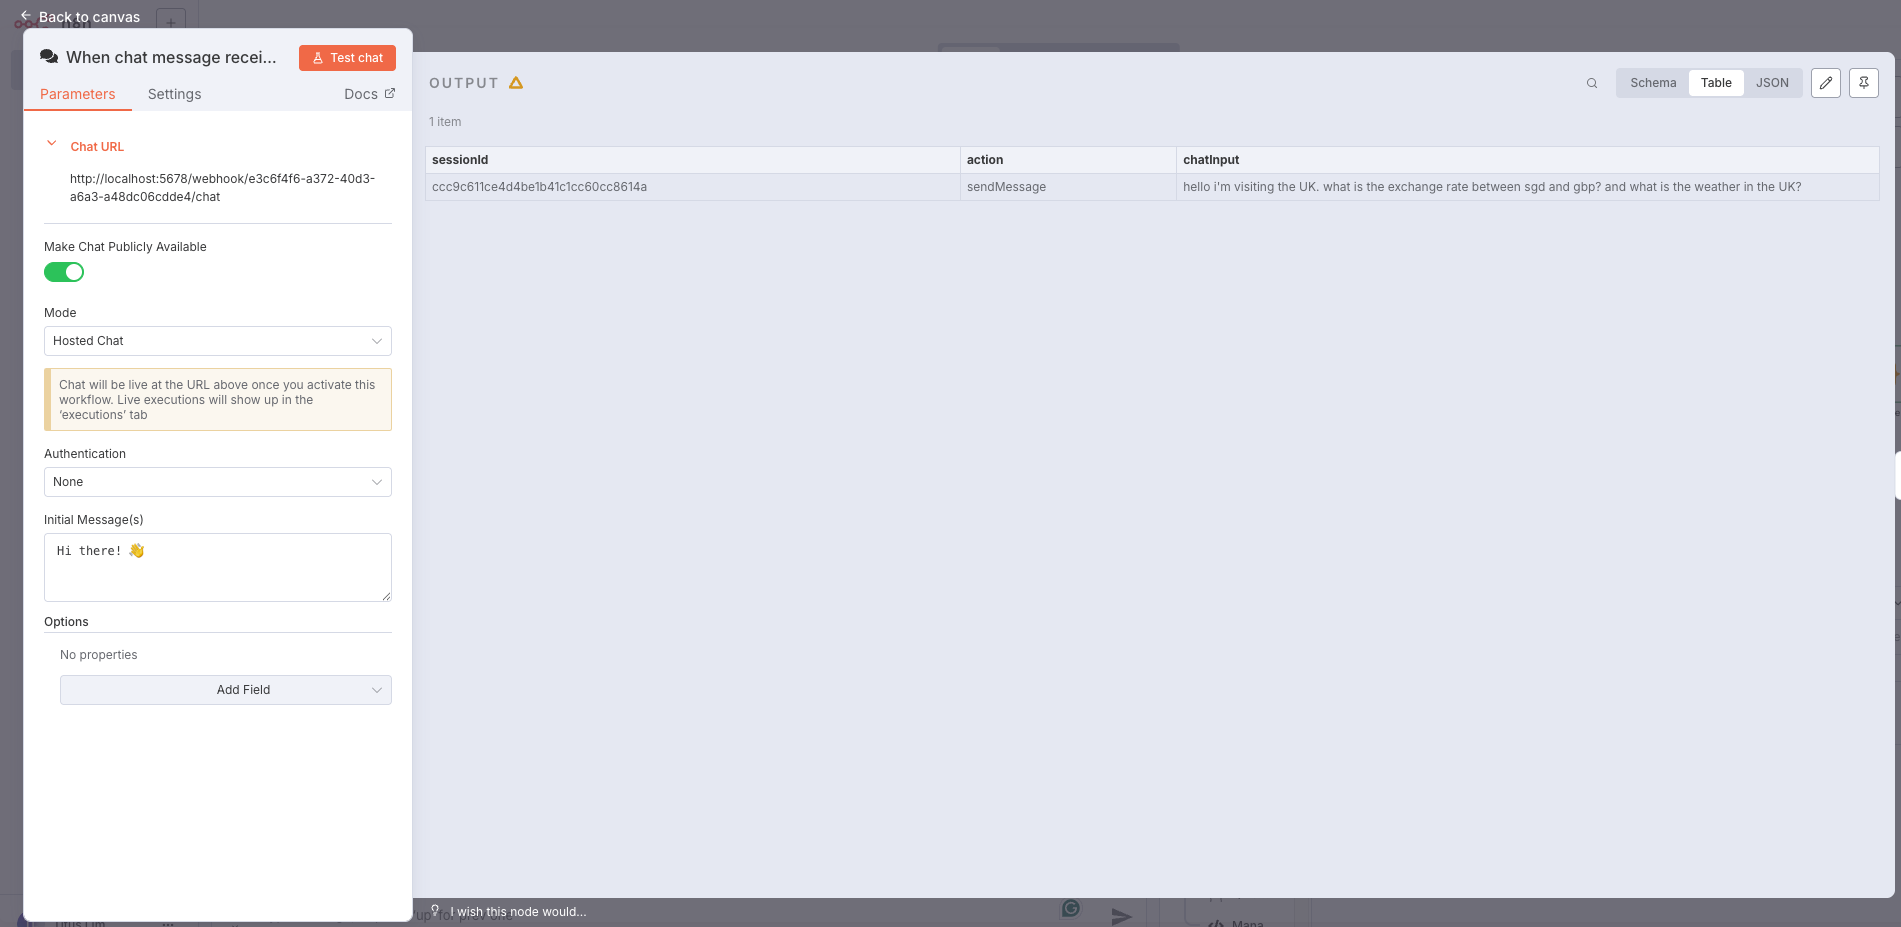

In [16]:
display(Image("../images/12. Make Chat Publicly Available.png"))

### This is the target workflow we want to achieve

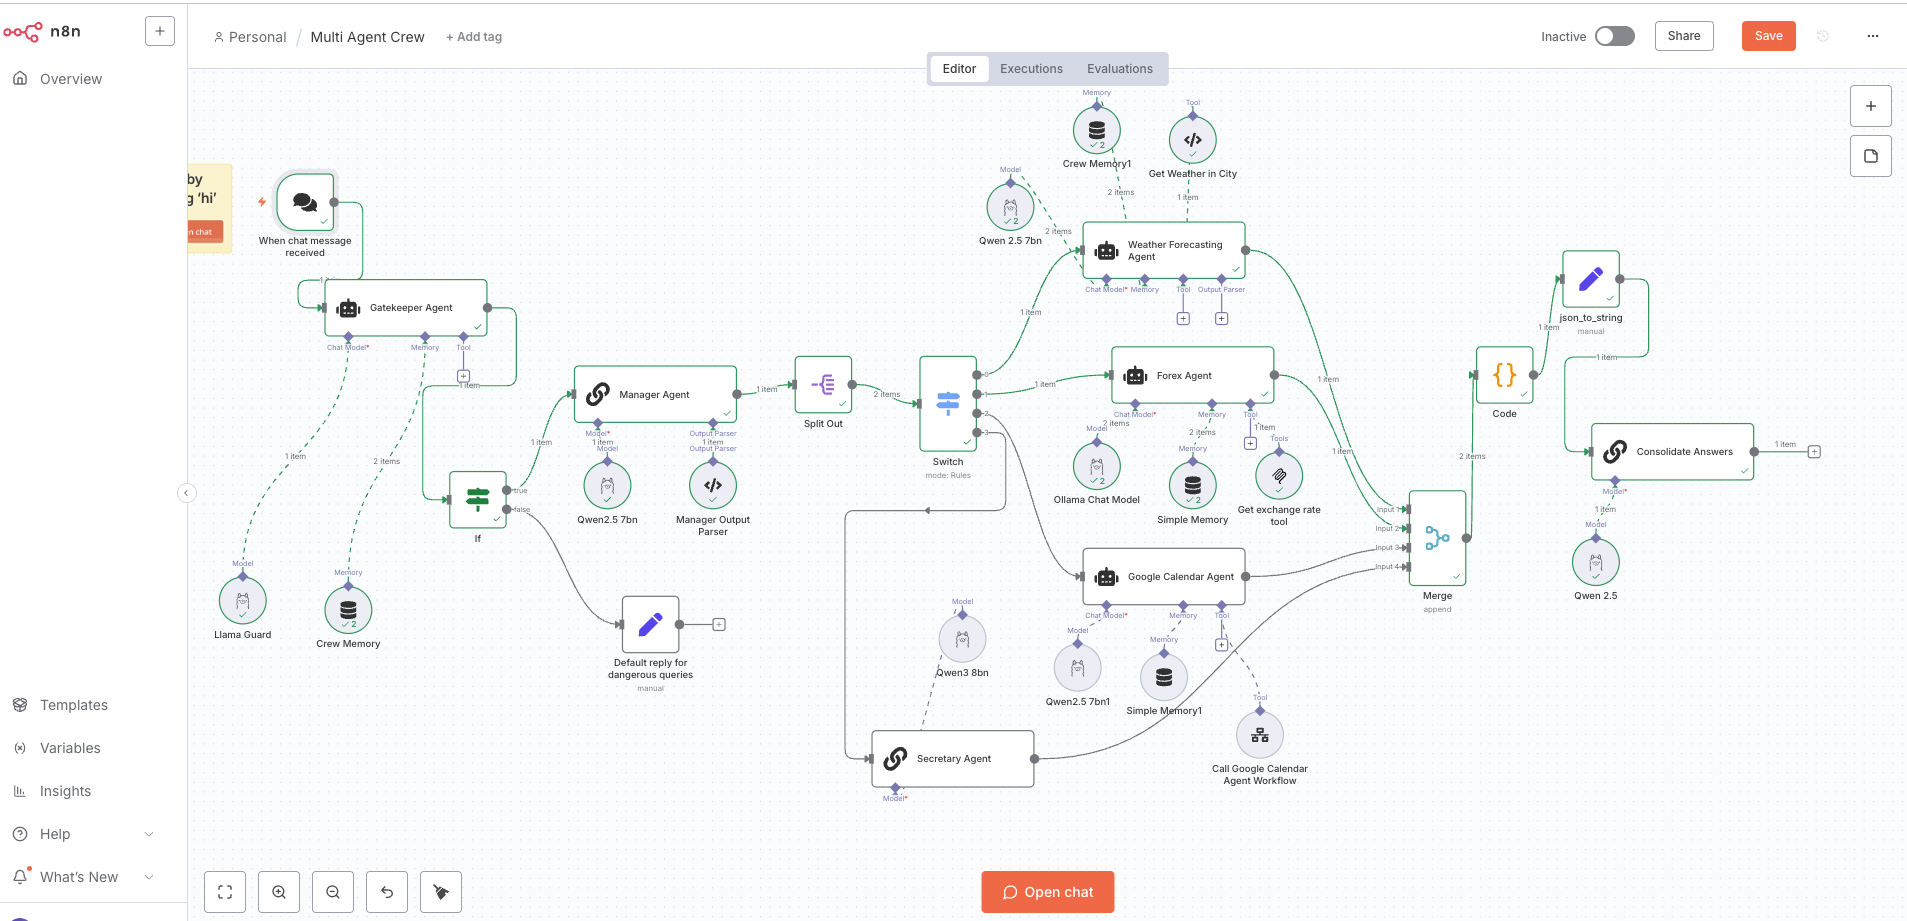

In [20]:
display(Image("../images/13. MultiAgentSystem.png"))

## The gatekeeper agent

Now, start adding your nodes one by one. I added a gatekeeper agent to filter away harmful questions, and passed on only the user's question to the manager agent if it's safe (using an `if` node).

> This node invokes a Llama Guard 3 under the hood which only returns safe/unsafe S<int> where S<int> is the classification reason for being unsafe.

The if statement detects when a statement is unsafe and routes it away from the agent crew.

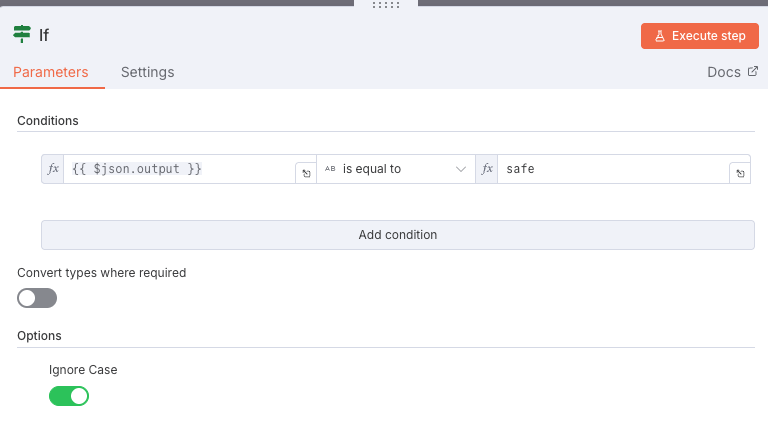

In [23]:
display(Image("../images/13. llamguard_if.png"))

## The manager agent

The manager agent is a `Basic LLM Chain` with a `Structured Output Parser` node to force the manager agent to return a list of assigned agents to the task.

The list is then passed to the `Split Out` node and routed to a `Switch` node which routes requests to the respective agents if invoked.

> Use the `Switch` node instead of the `If` node if there are multiple cases.

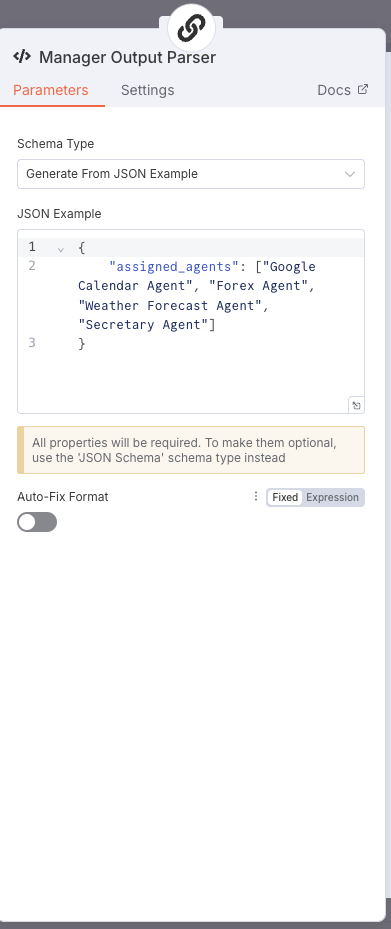

In [18]:
display(Image("../images/13. Manager Output Parser.png"))

## The weather forecasting agent

**The weather forecasting agent uses a code tool:** I wrote the script in Python. Each code node acts like a function in Python, but you don't have to write the typical `def (args)` statement above. Simply start coding off the logic that you need based on the input key from the previous node.

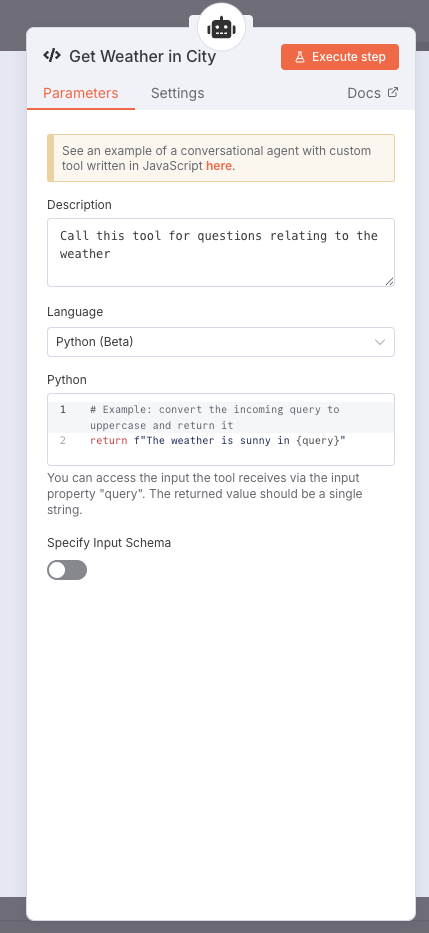

In [19]:
display(Image("../images/14. Code Tool.png"))

## The Forex agent
Note that the Forex agent has an MCP tool. Spin up the `forex_tool` with `python forex_tool.py` in the root directory. This spins up the MCP on localhost:3000/sse. 

**But the n8n service is unable to access a separate localhost deployment.** So you're either going to have to ngrok your MCP deployment again, or simply just pass in `http://host.docker.internal:3000/sse` instead. 

> This works because the n8n is spun using Docker so you can just point it to the docker's host port!

> Be sure to edit the node's name to increase the likelihood of the agent calling the tool

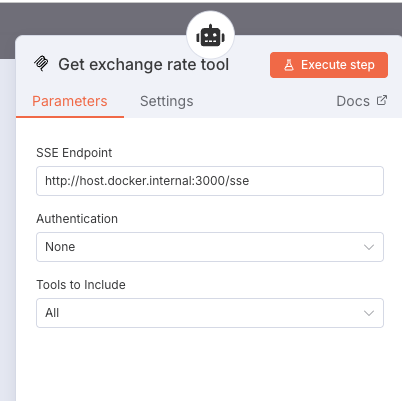

In [24]:
display(Image("../images/15. MCP_Tool.png"))

## The Google Calendar Agent

The Google calendar agent invokes the previous google calendar workflow as a tool!

Pull the `Call n8n Workflow Tool` node and connect it to the agent. N8n will very quickly allow you to connect to your other existing workflows

> Unfortunately you cannot see the workflow by your team mates on the community edition - unless you create your copy of their flow by importing their json file.

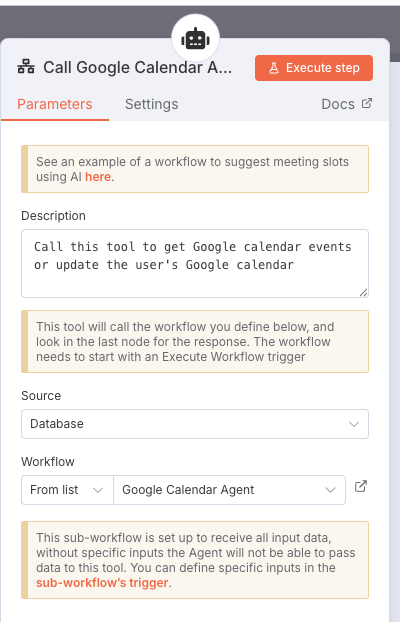

In [25]:
display(Image("../images/16. Invoke Subworkflow.png"))

## The Secretary Agent

Our multi-agent system should be able to still answer general questions (alternatively you could also turn out of scope questions). So I added another `Basic LLM Chain` to answer the user's question if none of the other agents pick it up.

## Merging the outputs by all agents

We need a way to consolidate the responses by all our agents. So I added a `merge` block. This block simply appends all the responses into a list.

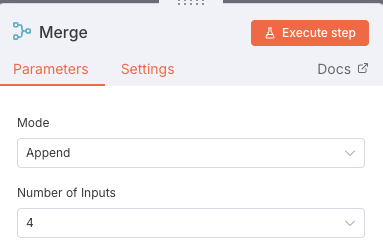

In [26]:
display(Image("../images/17. merge.png"))

The list is then passed to another Python code block that concatenates the strings in the list to a single string.

> This is where it can be troublesome to use n8n. n8n is JavaScript first and uses [Pyodide](https://pyodide.org/en/stable/), a package that runs Python code on the Node.js framework. You'll have to read the documentation to get past the bugs that you won't get in Python.

The code block also expects a json response regardless - so you have to wrap your final output into a json object.

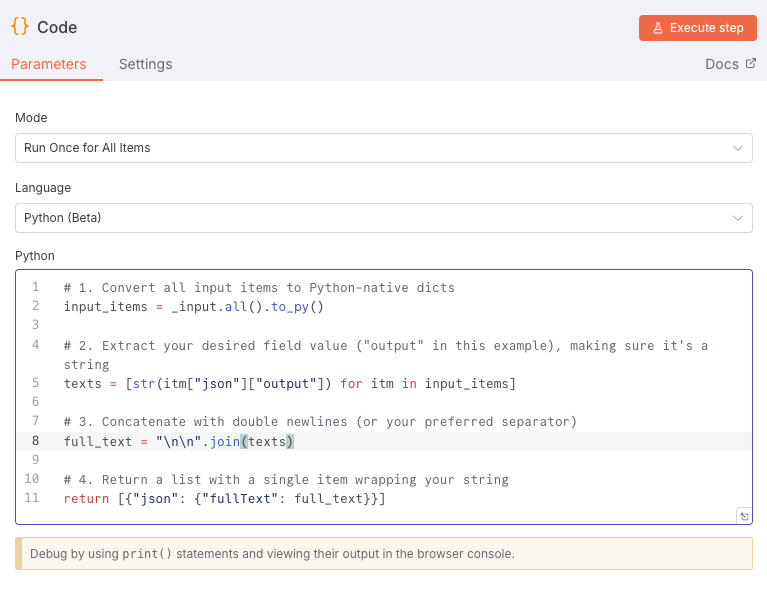

In [27]:
display(Image("../images/18. Code Block.png"))

Then we pass out the full text using a `Set` node - use this to set a variable to a specific value.

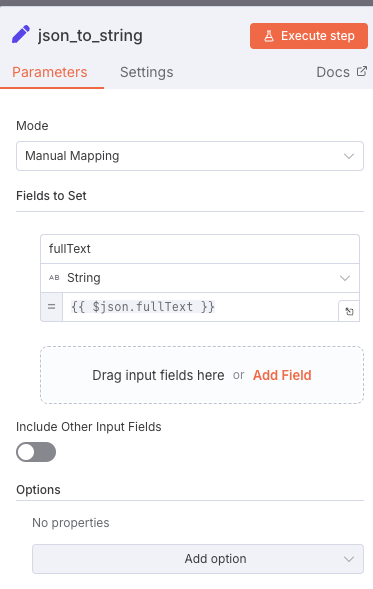

In [28]:
display(Image("../images/19. Set block.png"))

## Finally
Pass the concatenated string and the original user question to an LLM - another `basic LLM Chain` to generate the final answer

# Executing the Workflow

Open the Chat window and type a question!

In my case I typed "hello i'm visiting the UK. what is the exchange rate between sgd and gbp? and what is the weather in the UK?"

This passed through the workflow and the manager agent invoked both the forex agent and the weather agent - both agents also used their tools.

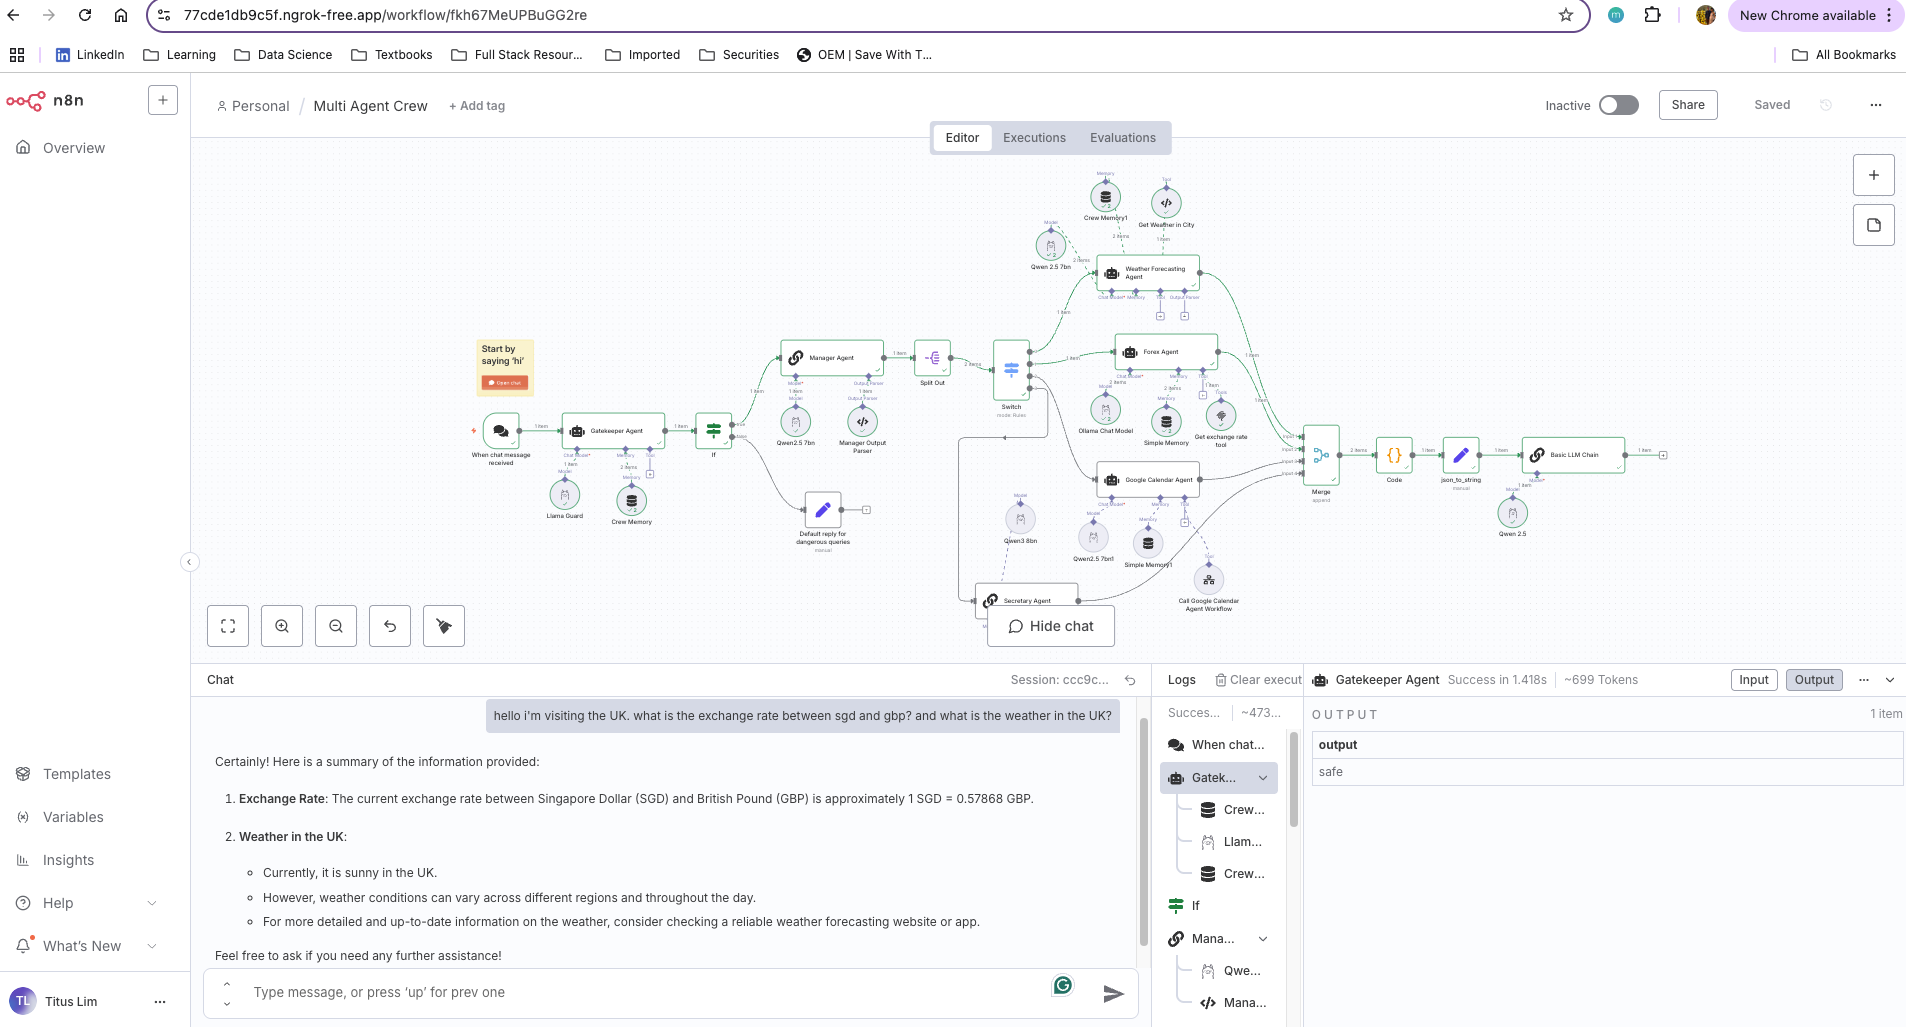

In [29]:
display(Image("../images/20. MultiAgentSystem_Executed.png"))

Notice that the edges executed in the workflow are lit up in green. In the actual experience, the edges light up as the execution happens, so it's in realtime.

# Public Chat

Click "Active" in the top right hand corner of your window and you'll be able to interact with the n8n public chat URL

> You can find this URL in your Chat Trigger Icon

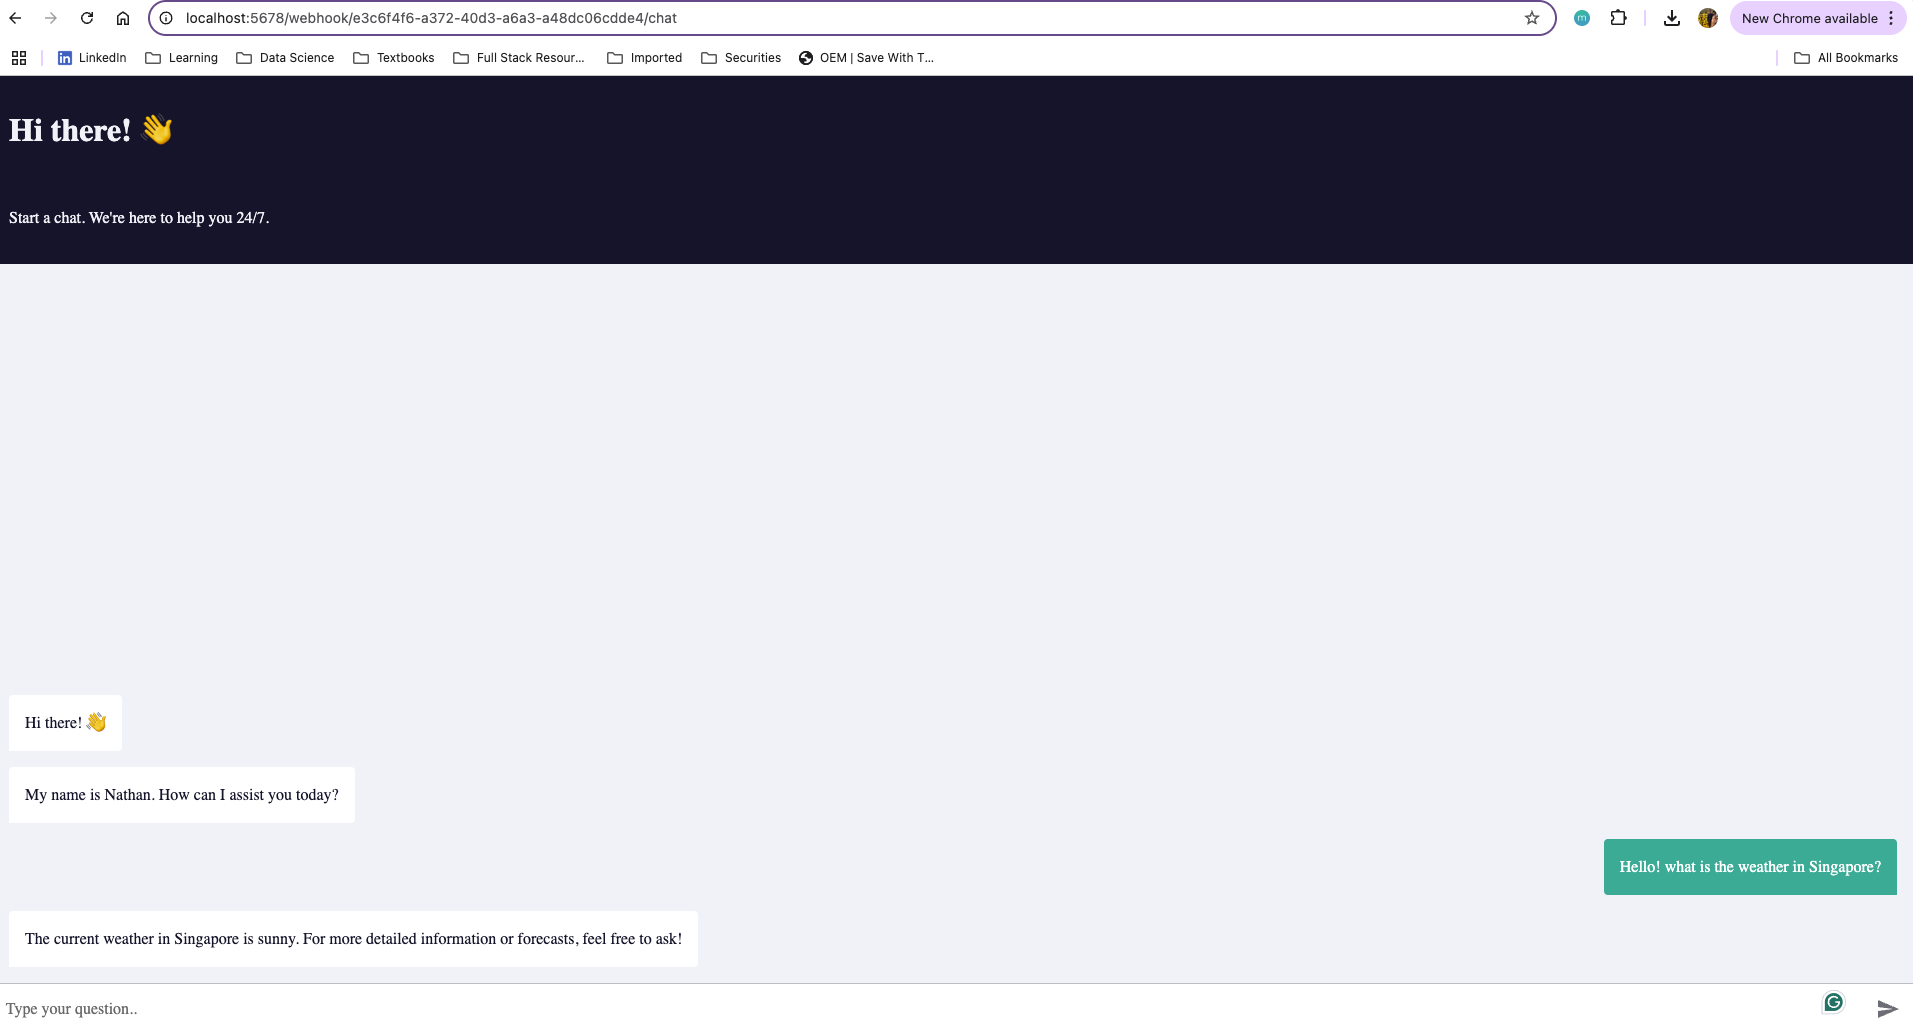

In [31]:
display(Image("../images/21. N8n public chat UI.png"))

# Deploying a Workflow to a REST API endpoint

To do this we'll need to change the trigger from the `Chat` trigger to a `Webhook` trigger. Simply pull the `Webhook` node and replace the `Chat` node at the front of your workflow.

In the webhook node, configure your API endpoints

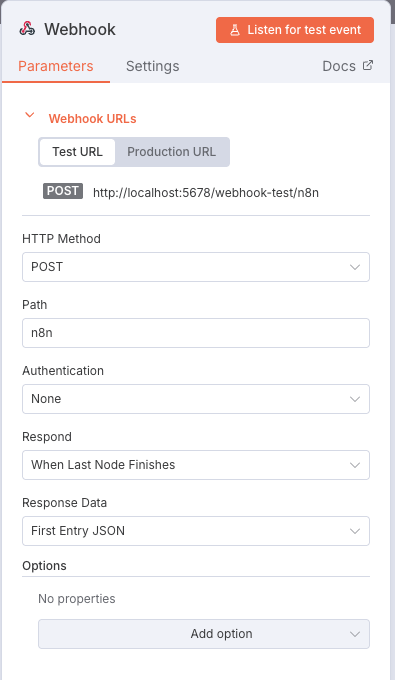

In [32]:
display(Image("../images/22. Set Endpoint.png"))

This is what your reworked flow should look like

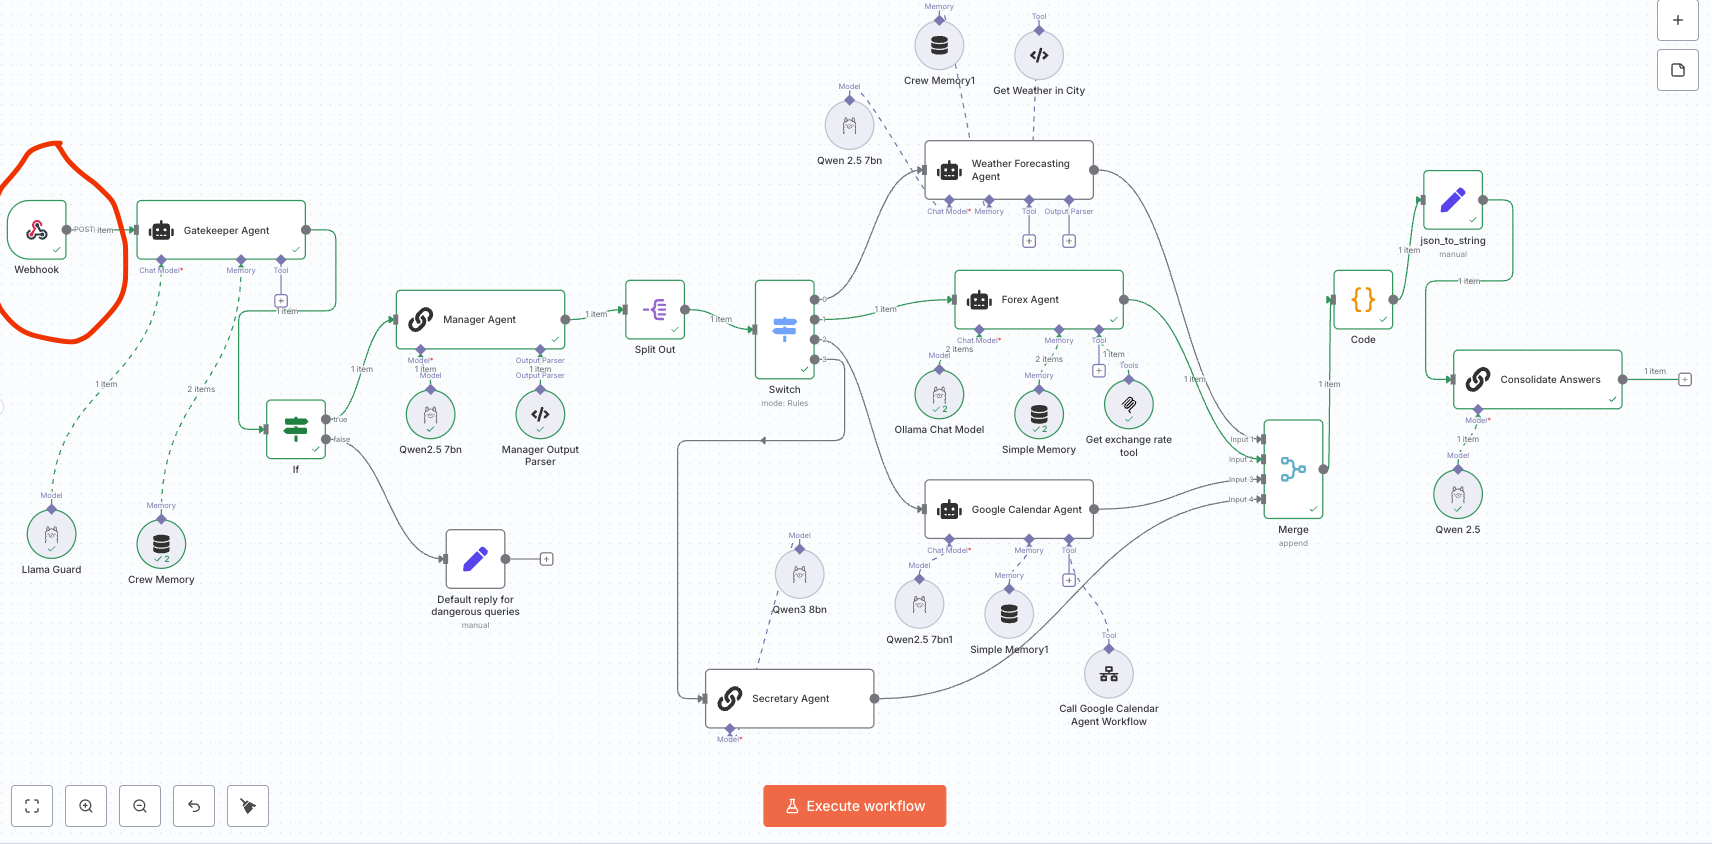

In [34]:
display(Image("../images/22. Rework flow.png"))